# Business Case 

A significant part of the sales at Albert Heijn are promotion sales. In order to run a successful promotion campaign, it is important to obtain an understanding of the uplift in sales of certain items when put on promotion. This is not only necessary to decide on what type of promotions to run, but also to get an idea on the required levels of stock to discuss with our suppliers. The Commerce Business Unit is developing a planning tool in which they want to see the effect of promotions for the upcoming weeks  

 

# Task 

* Target: Create one or more models to forecast the Unit Sales one week ahead in case of a promotion or no promotion on an article level. 

* Data: A redacted dataset is made available together with this assignment. This dataset contains daily sales of various AH products.. 

* Use the dataset.parquet file (containing data of 2016 and 2017) to build and evaluate your models. 

 

## Hard Requirements 

Note that the interview round will only go forward if all the below requirements are met: 

* Deadline <b>Monday 10:00 AM (Amsterdam Local Time)</b> before your scheduled interview 

* Your code is in <b>Python</b>

* Your solution is made in a <b>Jupyter Notebook</b>

* Your solution contains <b> at least the following components</b>: an EDA, a working model and model evaluation 

 

## Hints 

* Put your assumptions, decisions and approach in your Notebook (markdown) 

* Explain your Feature Engineering 

* Explain your Modeling choices 

* Explain your Model Evaluation and choice of metric(s). 

* Explain next steps to deploy your solution in production.

### Explanation of data: 

* DateKey: date identifier
* StoreCount: number of stores the article is available at
* ShelfCapacity: total capacity of shelfs over all stores
* PromoShelfCapacity: additional ShelfCapacity during promotion 
* UnitPromotionThreshold: minimal number of articles per basket before promotion is applied
* IsPromo: indicator if article is in promotion 
* national_holiday_[…]: indicator for specified holiday 
* SchoolHoliday[…]: indicator for holiday in north, middle or south part of NL 
* Temp[…]: minimal/maximum/average temperature of day 
* RainFallSum: total rainfall during the day (mm) 
* SundurationSum: total hours of sun during the day 
* MinAge: minimal accepted age to buy article 
* AlcoholPercentage: alcohol percentage of the article 
* CommunicationChannel: type of communication of promotion
* ItemNumber: item identification number
* CategoryCode: catergory identification number (product hierarchy) 
* GroupCode: group identification number (product hierarchy) 
* UnitSales: number of consumer units sold
* DiscountPercentage: discount percentage applied when threshold is reached 
* BasePrice: price of article when article is not in promotion

### Getting started
The data for this interview case is provided in a parquet file that can be loaded directly into a pandas dataframe as shown below. In order for reading parquet file make sure the pyarrow package is installed.

# Business Case

## 1. Explotory Data & Data Cleaning

The first step of the analysis is the Exploratory data analysis. The aim is:
- Discover Patterns
- Spot Anomalies
- Hypothesis &  Assumption


In [1]:
import pandas as pd
import warnings

# Constants
path = "./assets/dataset.parquet"
pd.set_option("display.max_columns", None)
warnings.filterwarnings('ignore')

## 1. First Overview Analysis

In [2]:
from src.ah_forecast_sales.utils.exploratory_analysis import get_data
from datetime import datetime
from pandarallel import pandarallel

# Path to the data parquet file
df = get_data(path)
print('Number of observation:', len(df))
print('Number of features:', len(list(df)))

# Useless Column (No different Value)
uselessColumns = [x for x in list(df) if len(df[x].unique()) == 1]
print(
    'Variable with an unique Value',
    uselessColumns
)
df = df.drop(columns=uselessColumns)

# Create Column dummies values only for Hollydays
isNationalHolidayColumns = [x for x in list(df) if 'national_holiday' in x]
df['isNationalHoliday'] = df[isNationalHolidayColumns].max(axis=1)
isSchoolHolidayColumns = [x for x in list(df) if 'SchoolHoliday' in x]
df[isSchoolHolidayColumns] = df[isSchoolHolidayColumns].fillna(0)
df['isSchoolHoliday'] = df[isSchoolHolidayColumns].sum(axis=1)


## Create a column for Years and month
df['years'] = df['DateKey'].apply(lambda x: str(x)[0:4])
df['month'] = df['DateKey'].apply(lambda x: str(x)[4:6])


# Column with NaN values
NaNColumns = [x for x in list(df) if len(df[df[x].isna()]) > 1 ]
for column in NaNColumns:
    print(
        'Variable with NaN Value for',
        column,
        len(df[df[column].isna()]) / len(df)
    )


# Transforn the DateKey to a proper variable
def func(x):
    return datetime.strptime(str(x), '%Y%m%d')

pandarallel.initialize()
df['DateKey'] = df.DateKey.parallel_apply(lambda x: func(x))

# Drop some observation with None Values ShelfCapacity / UnitSales - See explanation Markdown Below
df = df[
    (~df.ShelfCapacity.isna()) &
    (~df.UnitSales.isna())
]

categorical_variable = [
    x for x in list(df) if 'holiday' in x.lower()
] + [
    'IsPromo', 'ItemNumber', 'GroupCode', 'CategoryCode', 'CommunicationChannel'
]

df[categorical_variable] = df[categorical_variable].astype("category")

print('Number of observation:', len(df))
print('Number of features:', len(list(df)))

# Unist Sales is the data, we would like to 
df.head(3)

Number of observation: 1597612
Number of features: 35
Variable with an unique Value ['RainFallSum', 'MinAge', 'AlcoholPercentage']
Variable with NaN Value for ShelfCapacity 0.021527129240391282
Variable with NaN Value for UnitPromotionThreshold 0.9241167442407794
Variable with NaN Value for CommunicationChannel 0.923170957654299
Variable with NaN Value for UnitSales 0.06667388577451847
Variable with NaN Value for BasePrice 0.923170957654299
Variable with NaN Value for DiscountPercentage 0.923170957654299
INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Number of observation: 1479823
Number of features: 36


,DateKey,StoreCount,ShelfCapacity,PromoShelfCapacity,UnitPromotionThreshold,IsPromo,national_holiday_new_years_day,national_holiday_good_friday,national_holiday_easter_sunday,national_holiday_easter_monday,national_holiday_kings_day,national_holiday_rememberance_day,national_holiday_liberation_day,national_holiday_ascension,national_holiday_white_sunday,national_holiday_white_monday,national_holiday_christmas,national_holiday_boxing_day,SchoolHolidayMiddle,SchoolHolidayNorth,SchoolHolidaySouth,TempMin,TempMax,TempAvg,SundurationSum,CommunicationChannel,ItemNumber,CategoryCode,GroupCode,UnitSales,BasePrice,DiscountPercentage,isNationalHoliday,isSchoolHoliday,years,month
0,2016-01-04,221,3066.0,0,NaN,False,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,3.572222,4.527778,4.002315,1.733333,NaN,10032,7291,5572,1151.0,NaN,NaN,0,0.0,2016,01
1,2016-01-05,221,3066.0,0,NaN,False,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,3.083333,5.416667,4.355093,1.394444,NaN,10032,7291,5572,900.0,NaN,NaN,0,0.0,2016,01
2,2016-01-06,221,3066.0,0,NaN,False,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.911111,2.844444,2.303472,1.616667,NaN,10032,7291,5572,1017.0,NaN,NaN,0,0.0,2016,01


### Assumption & Decision about None Value

**SchoolHolidayNorth / SchoolHolidayMiddle / SchoolHolidaySouth**

69% of the time, they are NaN Values - two possibilities:
- The data cannot be used because the data is wrong.
- It supposed to be 0 but need to be clarified with the data provider.
This variable is only taking in account the summer vacation. 
until that point, the decision is to fill by 0, but lets see later if *they are a need to use it in a different way*.

**ShelfCapacity / UnitSales**

- **ShelfCapacity** is only 2% of the data, the decision is taken to drop them. We could use the mean or the median, or a technics for NaN values but not for this low amount of data.
- **UnitSales** is 6% of the data, but like it's the varibale, we want to forecast / modelize. This observation will be dropped and in a future we can use the future model to also fill the NaN values.

**BasePrice / DiscountPercentage / UnitPromotionThreshold**

The information is available when the product is on promotion. So we would like to keep it, and maybe later see the effect of this variable on the UnitsSales of this promotion.


## 2. Distribution of the features (including oultlier identification)

### A. Continious Variable 

In [3]:
import seaborn as sns

# Describe the colum only on the not continius variable
df.describe().astype(int)

,StoreCount,ShelfCapacity,PromoShelfCapacity,UnitPromotionThreshold,TempMin,TempMax,TempAvg,SundurationSum,UnitSales,BasePrice,DiscountPercentage
count,1479823,1479823,1479823,118558,1479823,1479823,1479823,1479823,1479823,120047,120047
mean,480,6447,63,1,7,13,10,5,1536,4,0
std,330,8603,882,0,5,6,6,2,6490,3,0
min,1,0,0,1,-5,-1,-3,0,1,0,0
25%,134,1490,0,1,3,8,6,3,38,1,0
50%,525,4321,0,1,7,13,10,4,162,3,0
75%,817,8983,0,2,12,19,16,6,732,5,0
max,934,220205,160260,6,19,31,24,13,350410,27,2


# and % Observation outlier for column 16994 0.9885161941664645
# and % Observation outlier for column 9706 0.9934411074838004
# and % Observation outlier for column 15248 0.9896960650023685


<AxesSubplot:ylabel='Density'>

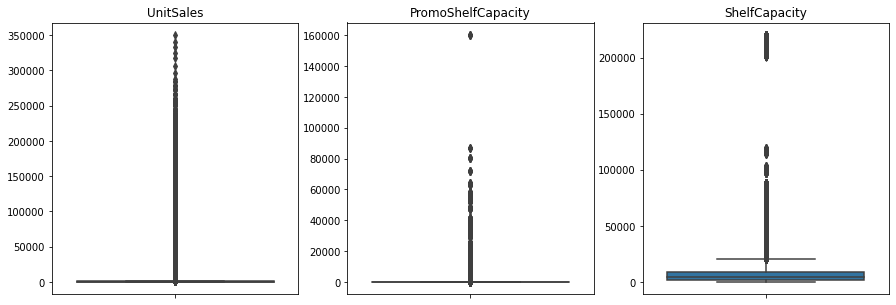

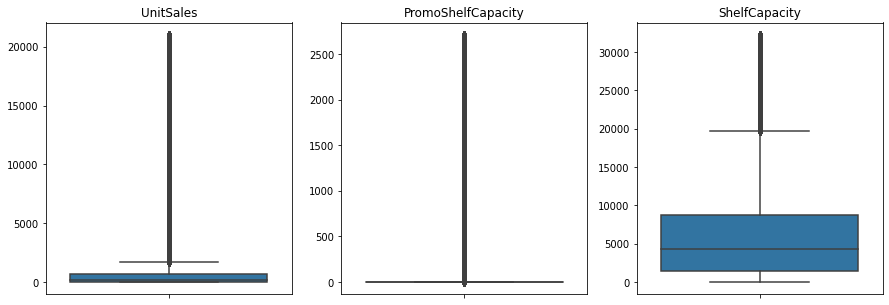

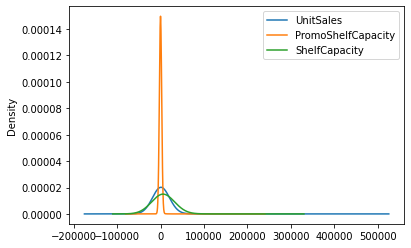

In [10]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

# Do we have outlier in UnitSales and PromoShelfCapacity and ShelfCapacity 
# the max is really high compare to the 0.75 percentile
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
for column, ax in zip(['UnitSales', 'PromoShelfCapacity', 'ShelfCapacity'], axes):
    ax = sns.boxplot(y=column, data=df, ax=ax)
    ax.set_ylabel('')
    ax.set_title(column)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

# Outliers are either 3×IQR or more above the third quartile or 3×IQR or more below the first quartile.
for column, ax in zip(['UnitSales', 'PromoShelfCapacity', 'ShelfCapacity'], axes):
    tmp = df[
        np.abs(df[column]-df[column].mean()) <= (3*df[column].std())
    ]
    print(
        '# and % Observation outlier for column',
        len(df) - len(tmp),
        len(tmp) / len(df)

    
    )
    ax = sns.boxplot(y=column, data=tmp, ax=ax)
    ax.set_ylabel('')
    ax.set_title(column)

df[['UnitSales', 'PromoShelfCapacity', 'ShelfCapacity']].plot.kde(bw_method=3)

#### Hypothesis and Decision making about the Outlier Values

We identify variable with possible outlier because their maximum is really higher than the 0.75 percentile.


1. For **PromoShelfCapacity** and **ShelfCapacity** we can vizualise some real outlier above 150000.
2. For **UnitSale**, its not really the case because its looks going up in a continuious way.

So far not decision has been taken about this data but important to keep in mind during the *modelisation & forecast*.


### B Categorical variables


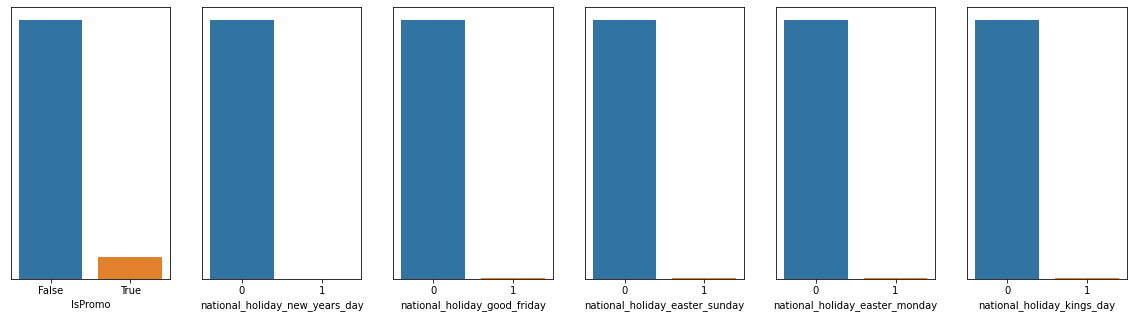

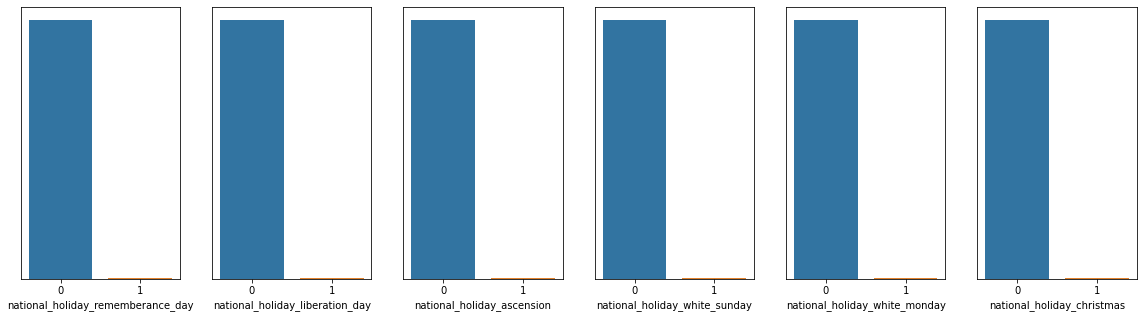

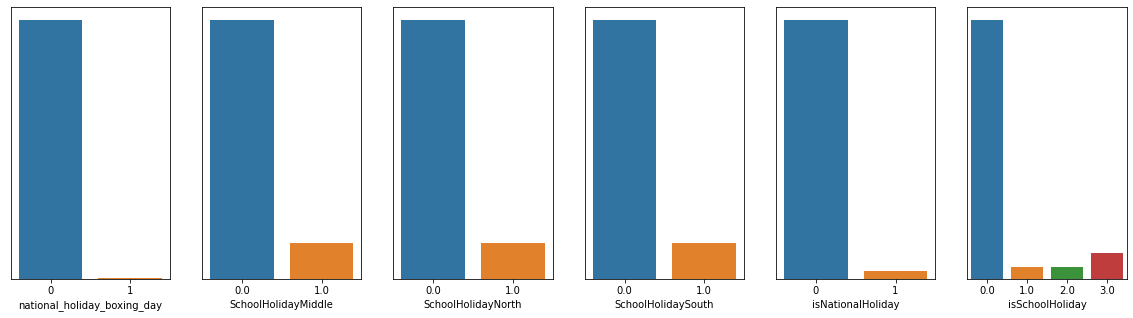

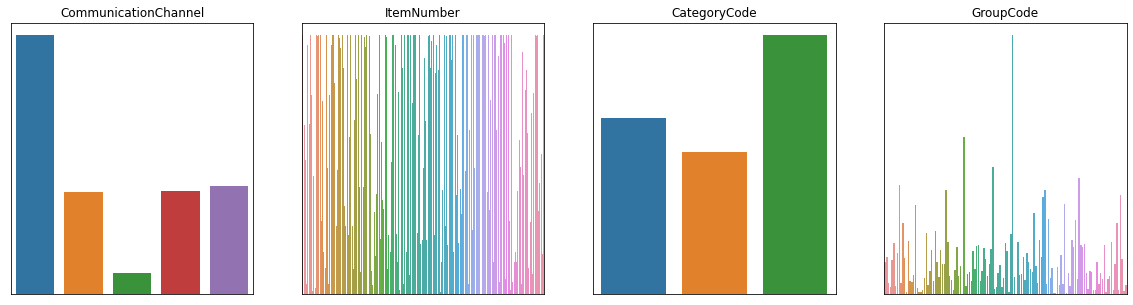

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1, 6, figsize=(20, 5), sharex=False)
for column, ax in zip(list(df.select_dtypes('category'))[0:6], axes):
    ax = sns.countplot(df[column], ax=ax)
    ax.get_yaxis().set_visible(False)

fig, axes = plt.subplots(1, 6, figsize=(20, 5), sharex=False)
for column, ax in zip(list(df.select_dtypes('category'))[6:12], axes):
    ax = sns.countplot(df[column], ax=ax)
    ax.get_yaxis().set_visible(False)

fig, axes = plt.subplots(1, 6, figsize=(20, 5), sharex=False)
for column, ax in zip(
    list(df.select_dtypes('category'))[12:16] + list(df.select_dtypes('category'))[20:22]
    , axes):
    ax = sns.countplot(df[column], ax=ax)
    ax.get_yaxis().set_visible(False)

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=False)
for column, ax in zip(list(df.select_dtypes('category'))[16:20], axes):
    ax = sns.countplot(df[column], ax=ax)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False),
    ax.set_title(column)


In [6]:
## Numner of Promo by year
print(
    'First Promotion appears at',
    df[df.IsPromo].sort_values('DateKey', ascending=True).DateKey.tolist()[0]
)

df.groupby(['years', 'IsPromo']).size().reset_index()

First Promotion appears at 2016-11-07 00:00:00


,years,IsPromo,0
0,2016,False,693104
1,2016,True,10636
2,2017,False,671059
3,2017,True,105024


1. The **National Holiday** is equal to 1, only in really few obseravations. It links to the fact this National Holiday happends only one day during the year. 

That's why the decision has been taken to **regroup all of them under a new features isNastionalHoliday which is the max value from all the individual the National Holiday.**


2. The **School Holiday** is different to the area in the Netherlands but we don't have any information about the location of the store.

But one Hypothesis we can have is:

*More we have people in vacation, can it effect the UnitSales in a positive or negative way?*

That's why the decision has been taken to **regroup all of them under a new features isShoolHoliday which is the sum value from all the individual the School Holiday.**

3. The **IsPromo** is one of the most important variable. Because we want to know what is the impact from the promotion on the UnitSales. but here the first promotion appear in November 2016 so either

a. Albert Heijn never use promotion before November 2016 for this product

b. Albert Heijn didn't track promotion before November 2016 for this product

That's quite important, because if we provide wrong labelled data in the model, we can excpect wrong forecast.
So if the issues is the tracking of the promotion before November. We may need to not use data before **November 2016**


4. **CommunicationChannel** is a variable available only when they is a promotion. It would be able to use it to answer to the hypothesis:

*Once we have a promotion, does the CommunicationChannel has impact on the UnitSales ?*


## 3. Correlation & Feature correlated to UnitSales

We use two different way to calculate the correlation between variable:

- Use the *Pearson correlation coefficient* to examine the strength and direction of the linear relationship between two **continuous variables**.
- a bar plot represents an estimate of *central tendency for a numeric variable *with  the height of each rectangle and provides some indication  of the uncertainty around that estimate using error bars


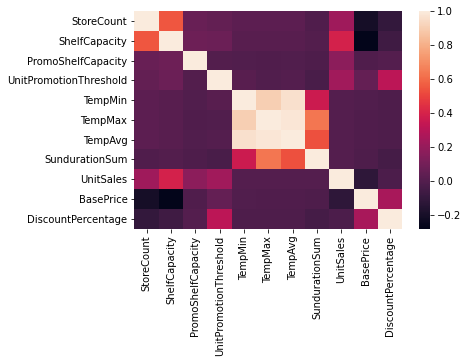

In [7]:
## Correlation for not dummies Variable
corrMatrix = df.corr()
sns.heatmap(corrMatrix)
plt.show()

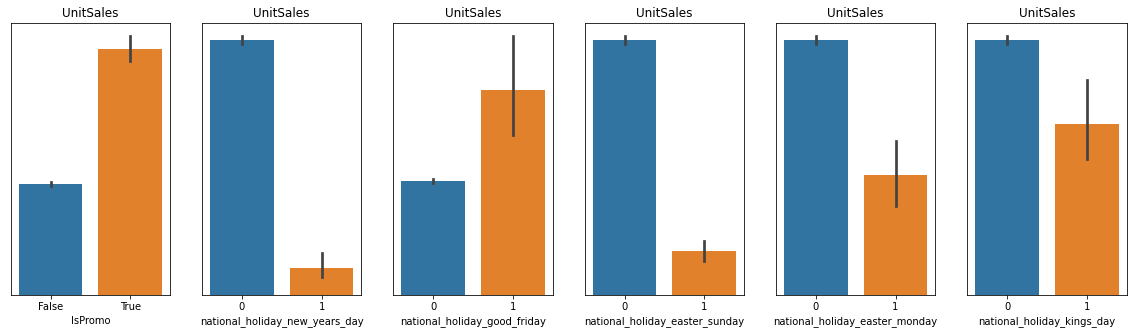

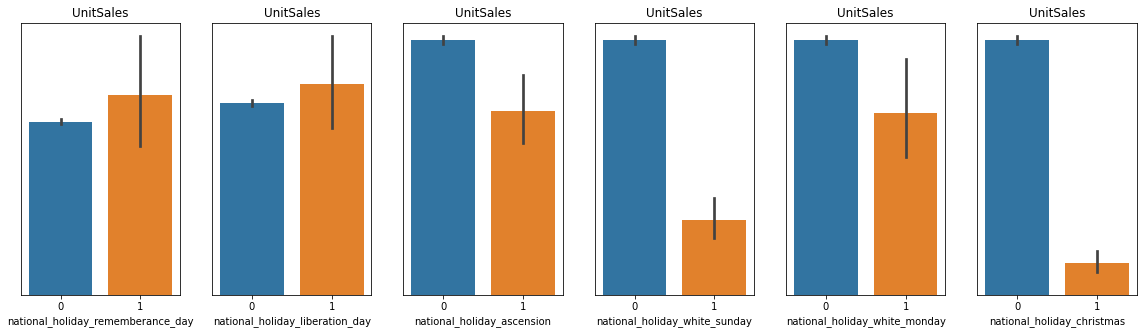

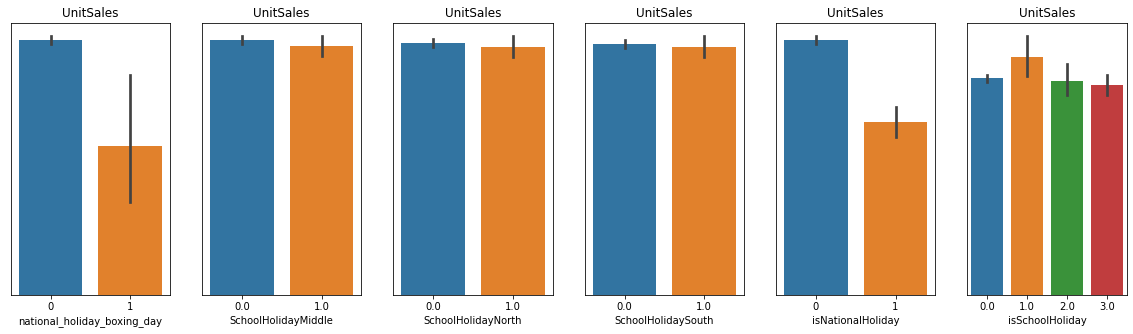

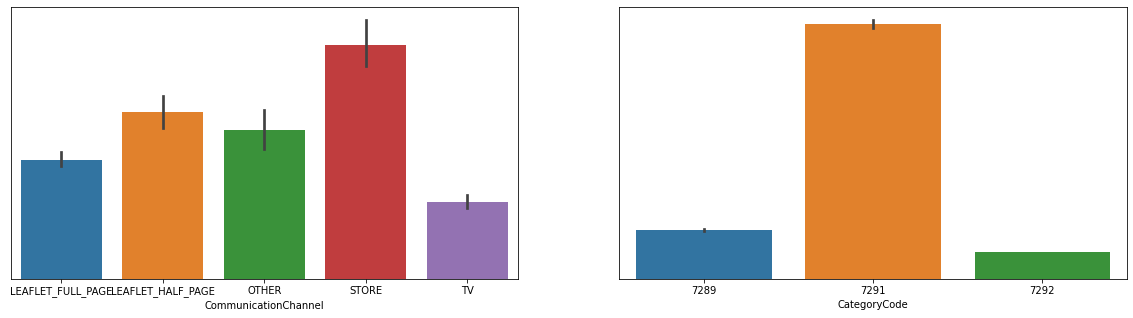

In [8]:
import seaborn as sns


fig, axes = plt.subplots(1, 6, figsize=(20, 5), sharex=False)
for column, ax in zip(list(df.select_dtypes('category'))[0:6], axes):
    ax = sns.barplot(
        x=column,
        y='UnitSales',
        data=df.sample(frac=0.2, random_state=1), 
        ax =ax
    )    
    ax.set_title('UnitSales')
    ax.get_yaxis().set_visible(False)

fig, axes = plt.subplots(1, 6, figsize=(20, 5), sharex=False)
for column, ax in zip(list(df.select_dtypes('category'))[6:12], axes):
    ax = sns.barplot(
        x=column,
        y='UnitSales',
        data=df.sample(frac=0.2, random_state=1),
        ax =ax
    )    
    ax.set_title('UnitSales')
    ax.get_yaxis().set_visible(False)

fig, axes = plt.subplots(1, 6, figsize=(20, 5), sharex=False)
for column, ax in zip(
    list(df.select_dtypes('category'))[12:16] + list(df.select_dtypes('category'))[20:22]
    , axes):
    ax = sns.barplot(
        x=column,
        y='UnitSales',
        data=df.sample(frac=0.2, random_state=1),
        ax =ax
    )    
    ax.set_title('UnitSales')   
    ax.get_yaxis().set_visible(False)


fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=False)
for column, ax in zip(
    list(df.select_dtypes('category'))[16:17] + list(df.select_dtypes('category'))[18:19]
    , axes):
    ax = sns.barplot(
        x=column,
        y='UnitSales',
        data=df.sample(frac=0.3, random_state=1),
        ax =ax
    )    
    ax.set_ylabel('UnitSales')
    ax.get_yaxis().set_visible(False)


From **UnitSales point of view**, they are correlated variable. This part is really important because it will help us to see wich variable we can use during the modelisation & forecast.

It's also important to notice that if we want to forecast the value of UnitSales using correlated variable. we also need to *have this information or to forecast it*.

In this case, they are different types of variable which is **impacted the UnitSales positively**:

- The **Supply variables**: StoreCount, ShelfCapacity -> More the product is available (store, Shelf), more the product is sold.
- The **Promotion variables**: PromotionShelfCapacity, UnitPromotionThreshold, IsPromo, COmmunicationChannel. -> A product on promotion is sold more nut depending on the promotion the UnitSales can also change.

To identify different type of promotion during the modelisation. It's important to know this information. For example the way of communication about the promotion will be able to explain between:

- **high and UnitSales at two differents time for the same product on promotion**


Also,  they are a negative correlation between NationalHolliday and the UnitSales. We could procceed this variable differently:

**Create a variable around the date for each National Holiday. For example the the effect of christmas on the sales effect more the weeks before christmas than the day by itself.**

## 4. Number of Item with enough informaton

# of item: 3199
# of item at least once in Promo: 2091
# of item at least 25 observation in 2017 in promotion and not in promotion: 1287


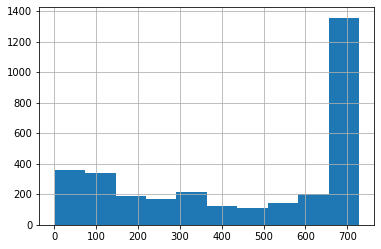

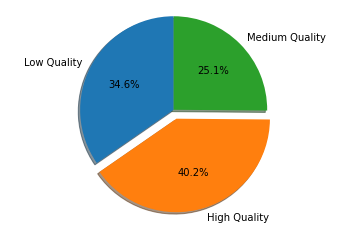

In [9]:
import sys
from src.ah_forecast_sales.utils.exploratory_analysis import get_sample
del sys.modules['src.ah_forecast_sales.utils.exploratory_analysis']
from src.ah_forecast_sales.utils.exploratory_analysis import get_sample
import matplotlib.pyplot as plt

## Get 
tmp = df.copy()
tmp.IsPromo = tmp.IsPromo.astype(bool)
sample = get_sample(tmp, sample_extract=False)

## item Universe
universe = len(df.ItemNumber.unique())
print(
    '# of item:',
    universe
)

## item universe with Promo
promo_universe = len(df[df.IsPromo].ItemNumber.unique())
print(
    '# of item at least once in Promo:',
    promo_universe
)

## item 25 observation (get 25 because of what we are going to use in Modelisation)
# There is a parameter for every changepoint in fbForecast(n_changepoints of them, default 25)
high_quality = len(sample.ItemNumber.unique())
print(
    '# of item at least 25 observation in 2017 in promotion and not in promotion:',
    high_quality
)


distribution = df.groupby(['ItemNumber']).size().reset_index().rename(
    columns={0: 'occurence'}
).sort_values('occurence')


distribution.occurence.hist()
distribution.describe()

# Pie chart
labels = 'Low Quality',  'High Quality', 'Medium Quality', 
sizes = [universe-promo_universe, high_quality, promo_universe-high_quality]
explode = (0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

The goal of the forecast is to modelise the UnitsSales on promotion or not. 
My assumption is to predict the future of the dataset (Like we have information from 2016 & 2017) i will try to forecast the **first week of 2018**

So the **requirement** of the data is:
- At least data with and without promo
- The data needed should be from 2017

Depending on the model, we are going to use we can have more requierement.

The quality of a forecast is based on the quality of the data which is feeded a model.

So far, we are going to work only and select the data based on the quality of the forecast of the high quality bucket.


In [ ]:
### KPI & information 